# Treinamento regressão

In [1]:
treinar = {
    'GP': False,
    'RegressaoLinear': True,
    'BayesianLinearRegression': True,
    'BayesianPolinomialLinearRegression': True,
    'BayesianLinearRegressionNew': True,
    'BayesianPolinomialLinearRegressionNew': True,
    'BayesianRBFLinearRegression': True,
}

In [2]:
# Métrica utilizada na otimização bayesiana para seleção do modelo
metrica = 'nlpd'

In [3]:
bo_max_iter=5#50

## Conjunto de dados

In [4]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv', index_col=0)

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Valor  |
| ---------------- | --------------------------------------------------- | ------ |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | `int: 0 false - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | `int: 0 false - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | `int: 0 false - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | `int: 0 false - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | `int: 0 false - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | `float` |
| `rooms`          | Quantidade de quartos                               | `int` |
| `bathroom`       | Quantidade de banheiros                             | `int` |
| `floor`          | Andar localizado o imóvel                           | `int`. `0` pressuposto para casa |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | `int: 0 false - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | `int: 0 false - 1 true` |
| `furniture`      | Se a casa já vem mobiliada                          | `int: 0 false - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | `float` |

In [5]:
dataset.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
3489,0,0,0,1,0,69,2,2,1,14,0,1,0,2125
669,1,0,0,0,0,450,4,5,6,1,1,1,0,12000
6003,0,0,0,0,1,61,3,1,1,2,0,1,0,1800
5333,1,0,0,0,0,54,2,2,1,2,0,1,0,2327
1524,0,0,0,1,0,85,3,2,1,7,0,1,0,2415


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [6]:
from sklearn.model_selection import train_test_split

# FIXME: Separar respeitando a proproção em cada cidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train[:50]
y_train = y_train[:50]

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (50, 13)
Quantidade de elementos selecionados para teste: (3207, 13)


### Normalização - AJEITAR

A normalização aplicada no conjunto de dados foi a [standard scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html):
\begin{aligned}
z = \frac{x_i - \mu_i}{\sigma_i}; \\
\mu_i = \frac{1}{N} \sum_{i=1}^N x_i; \\
\sigma_i = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu_i)^2}.
%A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.
\end{aligned}

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [7]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler

## Treinamento

Para cada um dos modelos avaliados, houve uma seleção dos hiperparâmetros por meio de uma Otimização Bayesiana (BO).
Em cada iteração da Otimização Bayesiana, era aplicada uma validação cruzada de _5-folds_.
A métrica definida para a busca dos melhores hiperparâmetros via BO foi a média do NLPD da validação cruzada. A métrica NLPD é descrita adiante neste trabalho.

Além da média do NLPD, os modelos foram avaliados por outras métricas, descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}.
\end{aligned}

In [8]:
from trabalho.util.metrica import rmse

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [9]:
from trabalho.util.metrica import nlpd

#### Mean absolute percentage error (MAPE)

A métrica **Mean Absolute Percentage Error** (MAPE),
também conhecida como **Mean absolute percentage deviation** (MAPD),
**FIXME**

\begin{aligned}
\text{MAPE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \frac{{}\left| y_i - \hat{y}_i \right|}{max(\epsilon, \left| y_i \right|)}
\end{aligned}
onde $\epsilon$ é um número arbitrário pequeno o suficiente para evitar resultados não definidos quando $y = 0$.

FALAR SOBRE, referências
* https://scikit-learn.org/dev/modules/model_evaluation.html#mean-absolute-percentage-error 
* https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac

In [10]:
from trabalho.util.metrica import mape

## Modelos utilizados

In [11]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold'])

### Processos Gaussianos

In [12]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [13]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    # Combinação de kernels
    #gpflow.kernels.Combination(),
    #gpflow.kernels.ChangePoints(),
    #gpflow.kernels.Product(),
    #gpflow.kernels.Sum(),
    
    # Imagem (convolução)
    #gpflow.kernels.Convolutional(),
    
    # Dados estacionários
    #gpflow.kernels.Stationary(),
    #gpflow.kernels.Periodic(), # Can be used to wrap any Stationary kernel to transform it into a periodic version
    #gpflow.kernels.AnisotropicStationary(), 
    #gpflow.kernels.IsotropicStationary(),
    
    # Multi objetivo
    #gpflow.kernels.MultioutputKernel(),
    #gpflow.kernels.IndependentLatent(),
    #gpflow.kernels.LinearCoregionalization(),
    #gpflow.kernels.SeparateIndependent(),
    #gpflow.kernels.SharedIndependent(),
    
    # Outros exóticos
    #gpflow.kernels.Coregion(),
    
    # Ok
    #gpflow.kernels.Kernel(), # Classe base
    #gpflow.kernels.Static(), # Classe base
    
    #gpflow.kernels.ArcCosine(),
    #gpflow.kernels.Constant(),
    #gpflow.kernels.Cosine(),
    #gpflow.kernels.Exponential(),
    #gpflow.kernels.Linear(),
    
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    #gpflow.kernels.Polynomial(),
    gpflow.kernels.SquaredExponential(), # RBF
    #gpflow.kernels.RationalQuadratic(),
    
    #gpflow.kernels.White(),
]


means = [
    # Padrão
    gpflow.mean_functions.Zero(),
    # Média
    gpflow.mean_functions.Linear(),
]

dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
    {
        'name': 'mean_function',
        'type': 'categorical',
        'domain': means
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel', 'type': 'categorical', 'domain': [0, 1, 2, 3]},
 {'name': 'mean_function', 'type': 'categorical', 'domain': [0, 1]}]

### Regressão Linear

#### Regressão Linear (não bayesiana)

In [14]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

##### Hiperparâmetros a serem procurados

In [15]:
dominio_regressao_linear = Dominio([])

#### Regressão Linear Bayesiana

In [16]:
from trabalho.modelos.bayesian_linear_regression import BayesianLinearRegression

BayesianLinearRegression

trabalho.modelos.bayesian_linear_regression.BayesianLinearRegression

In [17]:
from trabalho.modelos.bayesian_linear_regression_new import BayesianLinearRegressionNew

BayesianLinearRegressionNew

trabalho.modelos.bayesian_linear_regression_new.BayesianLinearRegressionNew

##### Hiperparâmetros a serem procurados

In [18]:
dominio_regressao_linear_bayesiana = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    }
])

In [19]:
dominio_regressao_linear_bayesiana_new = Dominio([
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 0.1)
    }
])

#### Regressão Linear Bayesiana Polinomial

In [20]:
from trabalho.modelos.bayesian_polinomial_linear_regression import BayesianPolinomialLinearRegression

BayesianPolinomialLinearRegression

trabalho.modelos.bayesian_polinomial_linear_regression.BayesianPolinomialLinearRegression

In [21]:
from trabalho.modelos.bayesian_polinomial_linear_regression_new import BayesianPolinomialLinearRegressionNew

BayesianPolinomialLinearRegressionNew

trabalho.modelos.bayesian_polinomial_linear_regression_new.BayesianPolinomialLinearRegressionNew

##### Hiperparâmetros a serem procurados

In [22]:
dominio_regressao_linear_bayesiana_polinomial = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

In [23]:
dominio_regressao_linear_bayesiana_polinomial_new = Dominio([
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 0.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

#### Regressão Linear Bayesiana com kernel RBF

In [24]:
from trabalho.modelos.bayesian_rbf_linear_regression import BayesianRBFLinearRegression

BayesianRBFLinearRegression

trabalho.modelos.bayesian_rbf_linear_regression.BayesianRBFLinearRegression

##### Hiperparâmetros a serem procurados

In [25]:
dominio_regressao_linear_bayesiana_rbf = Dominio([
#     {
#         'name': 'm0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
#     {
#         'name': 'S0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 1)
    },
    {
        'name': 'mean_rbf_arbitrario',
        'type': 'continuous',
        'domain': (-1, 1)
    },
    {
        'name': 'lambda_rbf_arbitrario',
        'type': 'continuous',
        'domain': (1e-7, 1)
    }
])

### Validação - Seleção de modelos

In [26]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm


def f(Modelo, X, y, metrica, k_folds, relatorio_geral, **kwargs):
    relatorio_parcial = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold', 'tentativa'])
    
    for fold, X_train, X_validation, y_train, y_validation in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        resultado = treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs)
        
        total_execucoes = len(relatorio_geral)
        tentativa = (total_execucoes - total_execucoes % k_folds) / k_folds
        
        relatorio_parcial.loc[len(relatorio_parcial)] = resultado + [fold, tentativa]
        relatorio_geral.loc[total_execucoes] = resultado + [fold, tentativa]


    medias = relatorio_parcial.mean()
    
    # Fixme: juntar com o relatório final
    #relatorio_parcial
    
    return medias[metrica]


def treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs):
    X_scaler = Scaler()
    y_scaler = Scaler()

    X_train_transform      = X_scaler.fit_transform(X_train)
    X_validation_transform = X_scaler.transform(X_validation)
    y_train_transform      = y_scaler.fit_transform(y_train)
    y_validation_transform = y_scaler.transform(y_validation)

    modelo = Modelo(**kwargs)
    modelo.fit(X_train_transform, y_train_transform)

    means, vars = modelo.predict(X_validation_transform)
    means = means.reshape((-1, 1))
    vars = vars.reshape((-1, 1))

    means_dimensao_correta = y_scaler.inverse_transform(means)
    std_errors_modelo = np.sqrt(vars)
    std_errors_scaler = np.sqrt(y_scaler.var_)
    
    vars_dimensao_correta = (std_errors_modelo * std_errors_scaler)**2

    erro_rmse = rmse(means_dimensao_correta, y_validation)
    erro_nlpd = nlpd(means_dimensao_correta, vars_dimensao_correta, y_validation)
    erro_mape = mape(means_dimensao_correta, y_validation)
    
    
    return [Modelo.__name__, kwargs, erro_rmse, erro_nlpd, erro_mape]


def otimizacao_bayesiana(Modelo, dominio, X, y, k_folds=5, metrica='nlpd', max_iter=50):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold', 'tentativa'])
    funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, k_folds=5, metrica=metrica, relatorio_geral=relatorio)

    bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
    bo.run_optimization(max_iter=max_iter)

    try:
        bo.plot_convergence()
        bo.plot_acquisition()
    except Exception as e:
        print(e)

    print(f'{metrica}:', bo.fx_opt)
    print('Parâmetros:', bo.x_opt)

    return relatorio

In [27]:
modelos = {
    'GP': (GP, dominio_gp),
    'RegressaoLinear': (RegressaoLinear, dominio_regressao_linear),
    'BayesianLinearRegression': (BayesianLinearRegression, dominio_regressao_linear_bayesiana),
    'BayesianPolinomialLinearRegression': (BayesianPolinomialLinearRegression, dominio_regressao_linear_bayesiana_polinomial),
    'BayesianLinearRegressionNew': (BayesianLinearRegressionNew, dominio_regressao_linear_bayesiana_new),
    'BayesianPolinomialLinearRegressionNew': (BayesianPolinomialLinearRegressionNew, dominio_regressao_linear_bayesiana_polinomial_new),
    'BayesianRBFLinearRegression': (BayesianRBFLinearRegression, dominio_regressao_linear_bayesiana_rbf),
}

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

GP False
RegressaoLinear True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 52.13it/s]


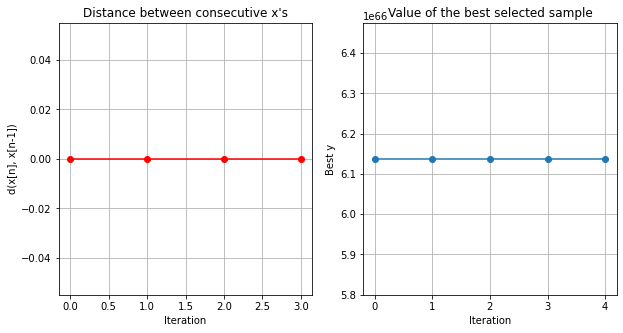

not enough values to unpack (expected 2, got 0)
nlpd: 6.13721446660353e+66
Parâmetros: []


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

BayesianLinearRegression True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 39.12it/s]


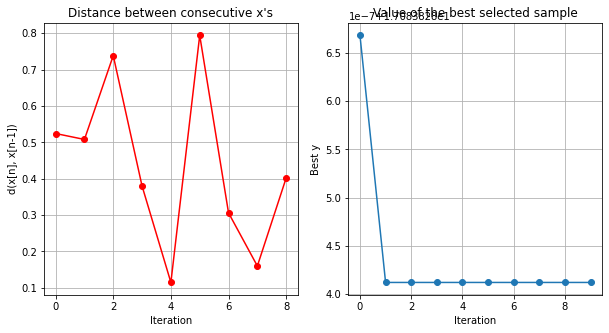

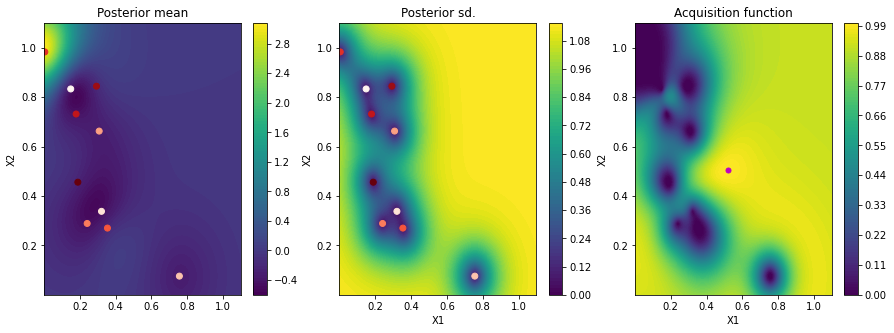

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

nlpd: 17.083828411810373
Parâmetros: [0.32069033 0.33780206]
BayesianPolinomialLinearRegression True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 20.32it/s]


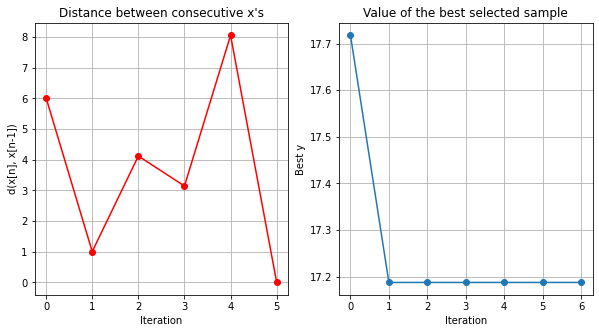

k-fold: 100%|██████████| 5/5 [00:00<00:00, 26.91it/s]

nlpd: 17.187539077614257
Parâmetros: [1.1 1.1 2. ]
BayesianLinearRegressionNew True



k-fold: 100%|██████████| 5/5 [00:00<00:00, 56.05it/s]


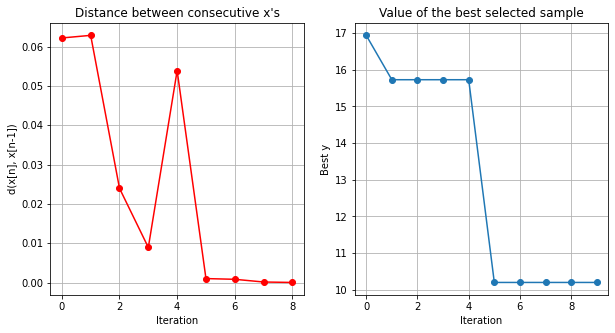

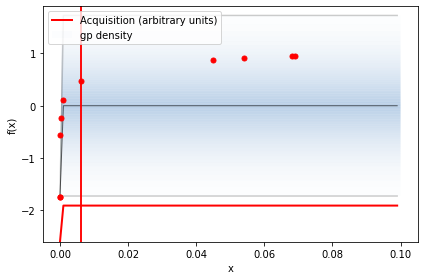

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

nlpd: 10.201258015952181
Parâmetros: [1.e-07]
BayesianPolinomialLinearRegressionNew True


k-fold: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


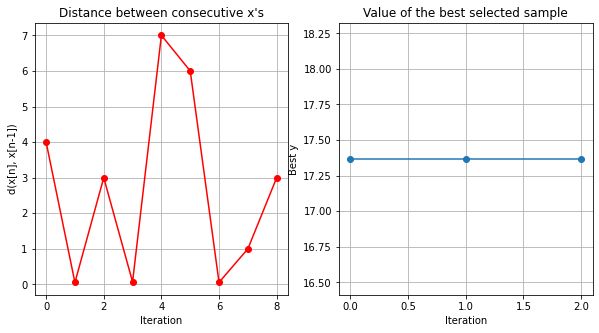

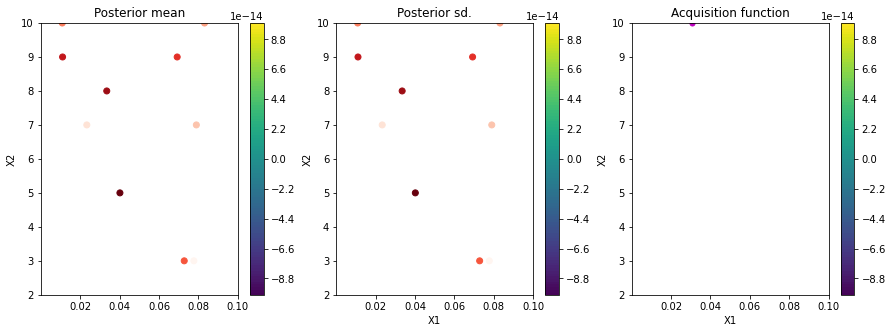

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

nlpd: nan
Parâmetros: [ 0.08312151 10.        ]
BayesianRBFLinearRegression True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 27.62it/s]


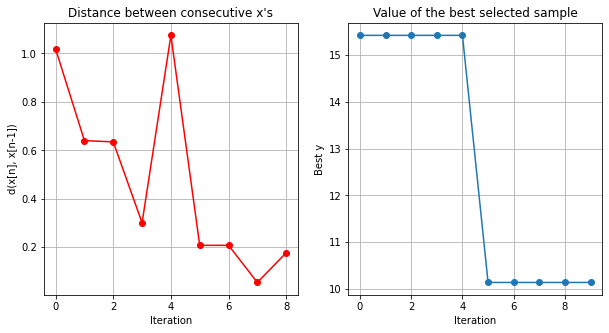

nlpd: 10.137478579144936
Parâmetros: [1.e-07 1.e+00 1.e-07]


In [28]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape', 'fold', 'tentativa'])


for modelo, (Classe, dominio) in modelos.items():
    print(modelo, treinar[modelo])
    if treinar[modelo]:
        resultado_parcial = otimizacao_bayesiana(Modelo=Classe, dominio=dominio, X=X_train, y=y_train, metrica=metrica, max_iter=bo_max_iter)
        relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
        resultado_parcial.to_csv(f'resultados/parciais/{modelo}_{metrica}.csv')

#### Resultado prelimiar

In [29]:
relatorio_condensado = \
relatorio_modelos.groupby(['modelo', 'tentativa']) \
                  .agg(['mean', 'std']) \
                  .reset_index() \
                  .sort_values(by=(metrica, 'mean')) \
                  .groupby('modelo').first()

relatorio_condensado

tentativa          rmse               \
                                                         mean          std   
modelo                                                                       
BayesianLinearRegression                    1.0   2935.124403   756.789197   
BayesianLinearRegressionNew                 5.0   3384.041317  1014.084033   
BayesianPolinomialLinearRegression          6.0   2980.710276  1200.723925   
BayesianPolinomialLinearRegressionNew       5.0  11458.754843  9411.057685   
BayesianRBFLinearRegression                 9.0   3763.269340   991.237277   
RegressaoLinear                             3.0   3384.041337  1014.084048   

                                               nlpd                    mape  \
                                               mean           std      mean   
modelo                                                                        
BayesianLinearRegression               1.708383e+01  1.121408e-01  0.720418   
BayesianLinearRegressionNew            1.020126e+01  2.300322e-01  1.048745   
BayesianPolinomialLinearRegression     1.718754e+01  1.531087e-01  0.560298   
BayesianPolinomialLinearRegressionNew  1.733563e+01  1.381678e-01  1.085491   
BayesianRBFLinearRegression            1.013748e+01  5.140908e-02  0.586903   
RegressaoLinear                        6.137214e+66  3.379533e+66  1.048745   

                                                 
                                            std  
modelo                                           
BayesianLinearRegression               0.337859  
BayesianLinearRegressionNew            0.492140  
BayesianPolinomialLinearRegression     0.352920  
BayesianPolinomialLinearRegressionNew  0.594095  
BayesianRBFLinearRegression            0.154462  
RegressaoLinear                        0.492140

### Resultado Final

In [30]:
melhores_hiperparametros = {}

for modelo, tentativa in relatorio_condensado[['tentativa']].reset_index().values:
    resultado = (relatorio_modelos.modelo == modelo) & (relatorio_modelos.tentativa == tentativa)
    melhores_hiperparametros[modelo] = relatorio_modelos[resultado].parametros.values[0]

pd.DataFrame(melhores_hiperparametros)

,BayesianLinearRegression,BayesianLinearRegressionNew,BayesianPolinomialLinearRegression,BayesianPolinomialLinearRegressionNew,BayesianRBFLinearRegression,RegressaoLinear
alphaInit,0.320690,NaN,1.1,NaN,NaN,NaN
lambdaInit,0.337802,NaN,1.1,NaN,NaN,NaN
sig2_error,NaN,1.000000e-07,NaN,0.072821,1.000000e-07,NaN
order,NaN,NaN,2.0,3.000000,NaN,NaN
mean_rbf_arbitrario,NaN,NaN,NaN,NaN,7.684998e-01,NaN
lambda_rbf_arbitrario,NaN,NaN,NaN,NaN,1.000000e-07,NaN


In [31]:
relatorio_final = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'mape'])


for i, (modelo, hiperparametros) in tqdm(enumerate(melhores_hiperparametros.items())):
    Modelo, dominio = modelos[modelo]
    resultado = treinar_modelo(Modelo, X_train, X_test, y_train, y_test, **hiperparametros)
                                         
    relatorio_final.loc[i] = resultado
    

# # Nome do arquivo
# nomes_modelos = relatorio.modelo.unique()
# nomes_modelos.sort()

# nome_arquivo = f'resultados/final/{fold_externo}_{metrica}_{"-".join(nomes_modelos)}.csv'
# relatorio.to_csv(nome_arquivo)
relatorio_final

6it [00:00, 11.70it/s]


,modelo,parametros,rmse,nlpd,mape
0,BayesianLinearRegression,"{'alphaInit': 0.3206903298669511, 'lambdaInit'...",8.612983e+03,1.709248e+01,1.833339
1,BayesianLinearRegressionNew,{'sig2_error': 1e-07},1.343584e+04,1.024623e+01,1.240525
2,BayesianPolinomialLinearRegression,"{'alphaInit': 1.1, 'lambdaInit': 1.1, 'order':...",3.636017e+05,1.715791e+01,2.066866
3,BayesianPolinomialLinearRegressionNew,"{'sig2_error': 0.07282141762072211, 'order': 3.0}",1.776355e+08,1.716498e+01,3.068321
4,BayesianRBFLinearRegression,"{'sig2_error': 1e-07, 'mean_rbf_arbitrario': 0...",4.199430e+03,1.014620e+01,0.615473
5,RegressaoLinear,{},1.343584e+04,9.026086e+67,1.240525
